In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score

import sys
sys.path.append('..')

from src.data_loader import DataLoader
from src.eda import EDA
from src.feature_engineering import FeatureEngineering

In [3]:
# Load the data
data_loader = DataLoader('../data/processed/processed_data.csv')
df = data_loader.load_data()

2024-06-06 21:39:17,516 - src.logger - INFO - Data loaded successfully from ../data/raw/data.csv
2024-06-06 21:39:17,516 - src.logger - INFO - Data loaded successfully from ../data/raw/data.csv


In [4]:
# Define RFMS variables
def calculate_rfms(df):
    # Convert TransactionStartTime to datetime and ensure timezone-naive
    df['TransactionStartTime'] = pd.to_datetime(df['TransactionStartTime']).dt.tz_localize(None)
    
    # Recency: Days since last transaction
    df['Recency'] = (pd.to_datetime('today') - df['TransactionStartTime']).dt.days
    
    # Frequency: Number of transactions per customer
    df['Frequency'] = df.groupby('CustomerId')['TransactionId'].transform('count')
    
    # Monetary: Total transaction amount per customer
    df['Monetary'] = df.groupby('CustomerId')['Amount'].transform('sum')
    
    # Spend: Average transaction amount per customer
    df['Spend'] = df.groupby('CustomerId')['Amount'].transform('mean')

    # Return RFMS DataFrame
    rfms = df[['CustomerId', 'Recency', 'Frequency', 'Monetary', 'Spend']].drop_duplicates().reset_index(drop=True)
    return rfms

# Calculate RFMS variables
rfms_df = calculate_rfms(df)

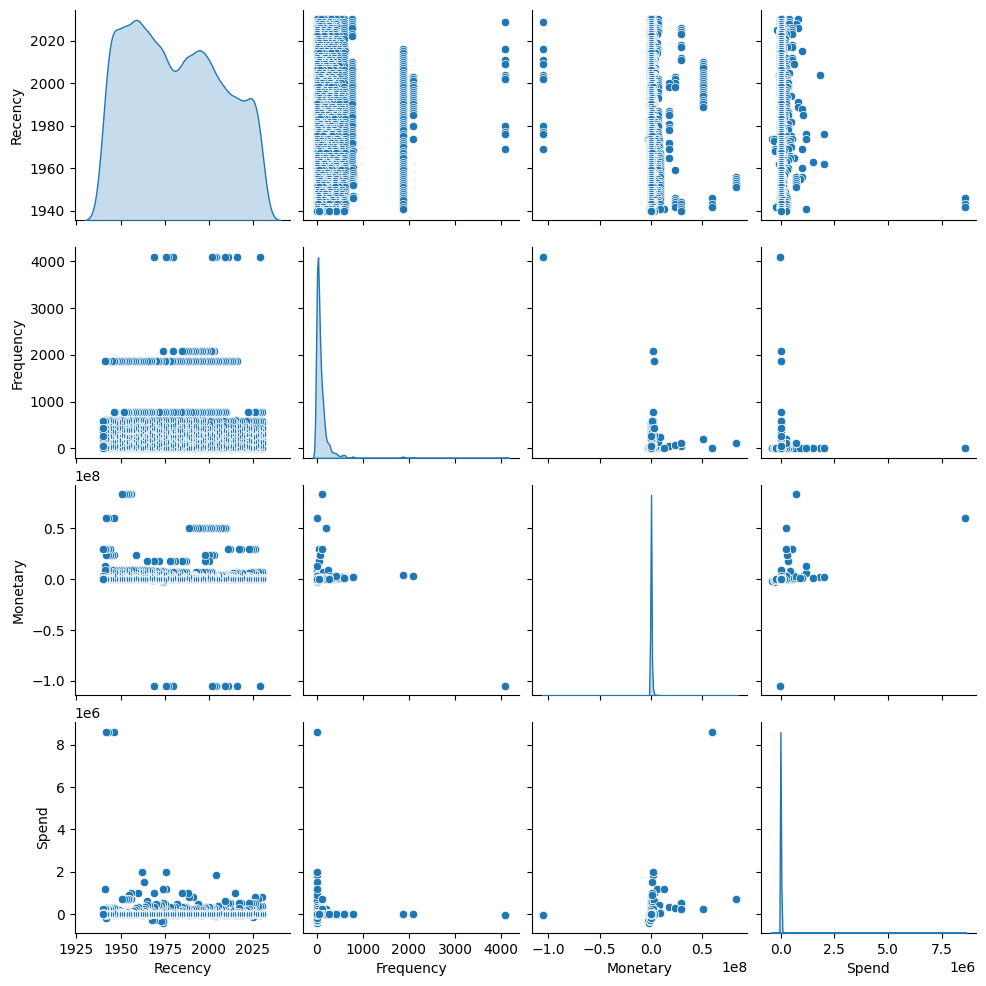

In [5]:
# Visualize RFMS variables
sns.pairplot(rfms_df, diag_kind='kde')
plt.show()

In [7]:
# Establish a boundary for good and bad labels
# This example uses a simple threshold based on the median of the RFMS score
rfms_df['RFMS_Score'] = (rfms_df['Recency'] + rfms_df['Frequency'] + rfms_df['Monetary'] + rfms_df['Spend']) / 4
threshold = rfms_df['RFMS_Score'].median()
rfms_df['Label'] = np.where(rfms_df['RFMS_Score'] >= threshold, 'Good', 'Bad')

# Display the RFMS DataFrame with labels
print(rfms_df.head())

        CustomerId  Recency  Frequency   Monetary        Spend    RFMS_Score  \
0  CustomerId_4406     2030        119  109921.75   923.712185  28248.615546   
1  CustomerId_4683     2030          2    1000.00   500.000000    883.000000   
2   CustomerId_988     2030         38  228727.20  6019.136842  59203.584211   
3  CustomerId_1432     2030          1    2000.00  2000.000000   1507.750000   
4  CustomerId_2858     2030         29   93400.00  3220.689655  24669.922414   

  Label  
0   Bad  
1   Bad  
2  Good  
3   Bad  
4   Bad  


In [8]:
# Establish a boundary for good and bad labels
# This example uses a simple threshold based on the median of the RFMS score
rfms_df['RFMS_Score'] = (rfms_df['Recency'] + rfms_df['Frequency'] + rfms_df['Monetary'] + rfms_df['Spend']) / 4
threshold = rfms_df['RFMS_Score'].median()
rfms_df['Label'] = np.where(rfms_df['RFMS_Score'] >= threshold, 1, 0)  # 1 for 'Good', 0 for 'Bad'

# Display the RFMS DataFrame with labels
print(rfms_df.head())

        CustomerId  Recency  Frequency   Monetary        Spend    RFMS_Score  \
0  CustomerId_4406     2030        119  109921.75   923.712185  28248.615546   
1  CustomerId_4683     2030          2    1000.00   500.000000    883.000000   
2   CustomerId_988     2030         38  228727.20  6019.136842  59203.584211   
3  CustomerId_1432     2030          1    2000.00  2000.000000   1507.750000   
4  CustomerId_2858     2030         29   93400.00  3220.689655  24669.922414   

   Label  
0      0  
1      0  
2      1  
3      0  
4      0  


In [9]:
def calculate_woe_iv(df, feature, target):
    # Calculate the number of events and non-events
    total_events = df[target].sum()
    total_non_events = df[target].count() - total_events
    
    # Create a DataFrame to store WoE and IV
    woe_iv_df = pd.DataFrame(columns=['Feature', 'Bin', 'WoE', 'IV'])
    
    # Calculate WoE and IV for each bin
    for bin in df[feature].unique():
        bin_events = df[df[feature] == bin][target].sum()
        bin_non_events = df[df[feature] == bin][target].count() - bin_events
        
        # Prevent division by zero and log(0)
        if bin_non_events == 0:
            bin_non_events = 1
        if bin_events == 0:
            bin_events = 1
        
        woe = np.log((bin_events / total_events) / (bin_non_events / total_non_events))
        
        # Replace infinite WoE with a large finite value
        if np.isinf(woe):
            woe = np.sign(woe) * 10
        
        iv = (bin_events / total_events - bin_non_events / total_non_events) * woe
        woe_iv_df = pd.concat([woe_iv_df, pd.DataFrame({'Feature': [feature], 'Bin': [bin], 'WoE': [woe], 'IV': [iv]})], ignore_index=True)
    
    # Calculate total IV
    total_iv = woe_iv_df['IV'].sum()
    
    # Transform the feature using WoE
    woe_transformed = df[feature].map(woe_iv_df.set_index('Bin')['WoE'])
    
    return woe_transformed, total_iv

In [10]:
# Transform RFMS variables using WoE
for feature in ['Recency', 'Frequency', 'Monetary', 'Spend']:
    rfms_df[feature + '_WoE'], iv = calculate_woe_iv(rfms_df, feature, 'Label')
    print(f'Information Value (IV) for {feature}: {iv}')

C:\Users\matiwos.desalegn\AppData\Local\Temp\ipykernel_20388\3752149233.py:27: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  woe_iv_df = pd.concat([woe_iv_df, pd.DataFrame({'Feature': [feature], 'Bin': [bin], 'WoE': [woe], 'IV': [iv]})], ignore_index=True)
C:\Users\matiwos.desalegn\AppData\Local\Temp\ipykernel_20388\3752149233.py:27: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  woe_iv_df = pd.concat([woe_iv_df, pd.DataFrame({'Feature': [feature], 'Bin': [bin], 'WoE': [woe], 'IV': [iv]})], ignor

Information Value (IV) for Recency: 0.047741375290084896
Information Value (IV) for Frequency: 3.9546326571547006


C:\Users\matiwos.desalegn\AppData\Local\Temp\ipykernel_20388\3752149233.py:27: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  woe_iv_df = pd.concat([woe_iv_df, pd.DataFrame({'Feature': [feature], 'Bin': [bin], 'WoE': [woe], 'IV': [iv]})], ignore_index=True)


Information Value (IV) for Monetary: 5.652358891440926


C:\Users\matiwos.desalegn\AppData\Local\Temp\ipykernel_20388\3752149233.py:27: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  woe_iv_df = pd.concat([woe_iv_df, pd.DataFrame({'Feature': [feature], 'Bin': [bin], 'WoE': [woe], 'IV': [iv]})], ignore_index=True)


Information Value (IV) for Spend: 5.439147553238849


In [11]:
# Check for infinite values in the transformed dataframe
print("Checking for infinite values in the transformed dataframe...")
print(np.isinf(rfms_df[['Recency_WoE', 'Frequency_WoE', 'Monetary_WoE', 'Spend_WoE']]).sum())

Checking for infinite values in the transformed dataframe...
Recency_WoE      0
Frequency_WoE    0
Monetary_WoE     0
Spend_WoE        0
dtype: int64


In [12]:
# Replace any remaining infinite values with a large finite number
rfms_df.replace([np.inf, -np.inf], 10, inplace=True)

In [13]:
# Prepare the data for logistic regression
X = rfms_df[['Recency_WoE', 'Frequency_WoE', 'Monetary_WoE', 'Spend_WoE']]
y = rfms_df['Label']

In [14]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [15]:
# Train a logistic regression model
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

In [16]:
# Predict on the test set
y_pred = model.predict(X_test)
y_pred_prob = model.predict_proba(X_test)[:, 1]

In [17]:
# Evaluate the model
auc = roc_auc_score(y_test, y_pred_prob)
accuracy = accuracy_score(y_test, y_pred)
print(f'AUC: {auc}')
print(f'Accuracy: {accuracy}')

AUC: 0.9998362708623062
Accuracy: 0.9955745460094613


## Load and Check Data
### First, let's load the data and check the data types to ensure all values are numerical.

In [9]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve

# Load the data
data = pd.read_csv('../data/processed/processed_data.csv')

# Check data types
print("Data Types:\n", data.dtypes)

# Check for non-numerical values
print("Non-Numerical Columns:\n", data.select_dtypes(exclude=[np.number]).columns)

# Ensure all features are numerical
data = pd.get_dummies(data)

Data Types:
 TransactionId                 int64
BatchId                       int64
AccountId                     int64
SubscriptionId                int64
CustomerId                    int64
CurrencyCode                 object
CountryCode                 float64
ProviderId                   object
ProductId                    object
ProductCategory              object
ChannelId                    object
Amount                      float64
Value                       float64
TransactionStartTime         object
PricingStrategy             float64
FraudResult                 float64
TotalTransactionAmount      float64
AverageTransactionAmount    float64
TransactionCount            float64
TransactionStdDev           float64
TransactionHour               int64
TransactionDay                int64
TransactionMonth              int64
TransactionYear               int64
dtype: object
Non-Numerical Columns:
 Index(['CurrencyCode', 'ProviderId', 'ProductId', 'ProductCategory',
       'ChannelI

## Model Selection and Training
### Split the data into training and testing sets, then choose and train the models.

In [10]:
# Split the data into features and target
X = data.drop('target', axis=1)  # Assuming the target column is named 'target'
y = data['target']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize models
log_reg = LogisticRegression(max_iter=1000)
dec_tree = DecisionTreeClassifier()
rand_forest = RandomForestClassifier()
gbm = GradientBoostingClassifier()

# Train the models
log_reg.fit(X_train, y_train)
dec_tree.fit(X_train, y_train)
rand_forest.fit(X_train, y_train)
gbm.fit(X_train, y_train)

KeyError: "['target'] not found in axis"

## Hyperparameter Tuning
### Use Grid Search or Random Search for hyperparameter tuning.

In [ ]:
# Hyperparameter tuning for Logistic Regression
param_grid_log_reg = {
    'C': [0.01, 0.1, 1, 10, 100]
}
grid_search_log_reg = GridSearchCV(log_reg, param_grid_log_reg, cv=5, scoring='roc_auc')
grid_search_log_reg.fit(X_train, y_train)

# Hyperparameter tuning for Decision Tree
param_grid_dec_tree = {
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5, 10]
}
grid_search_dec_tree = GridSearchCV(dec_tree, param_grid_dec_tree, cv=5, scoring='roc_auc')
grid_search_dec_tree.fit(X_train, y_train)

# Hyperparameter tuning for Random Forest
param_grid_rand_forest = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5]
}
random_search_rand_forest = RandomizedSearchCV(rand_forest, param_grid_rand_forest, n_iter=10, cv=5, scoring='roc_auc', random_state=42)
random_search_rand_forest.fit(X_train, y_train)

# Hyperparameter tuning for GBM
param_grid_gbm = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'subsample': [0.8, 0.9, 1.0]
}
random_search_gbm = RandomizedSearchCV(gbm, param_grid_gbm, n_iter=10, cv=5, scoring='roc_auc', random_state=42)
random_search_gbm.fit(X_train, y_train)

## Model Evaluation
### Evaluate the models using accuracy, precision, recall, F1 score, and ROC-AUC.

In [ ]:
# Evaluate the models
models = {
    'Logistic Regression': grid_search_log_reg.best_estimator_,
    'Decision Tree': grid_search_dec_tree.best_estimator_,
    'Random Forest': random_search_rand_forest.best_estimator_,
    'Gradient Boosting': random_search_gbm.best_estimator_
}

for model_name, model in models.items():
    y_pred = model.predict(X_test)
    y_pred_prob = model.predict_proba(X_test)[:, 1]
    print(f"Model: {model_name}")
    print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
    print(f"Precision: {precision_score(y_test, y_pred)}")
    print(f"Recall: {recall_score(y_test, y_pred)}")
    print(f"F1 Score: {f1_score(y_test, y_pred)}")
    print(f"ROC-AUC: {roc_auc_score(y_test, y_pred_prob)}")
    print("-" * 30)

    # Plot ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc_score(y_test, y_pred_prob):.2f})')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()